In [1]:
from scipy.optimize import leastsq,curve_fit
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.path as mpltPath
import math as math
from scipy.optimize import curve_fit

Defino funciones y parametros que voy a usar luego. Dist me calcula la distancia euclediana entre dos puntos. Func es el modelo lineal que paso como parametro al LeastSq. 

In [4]:
poligono = [[-216.5,-375],[216.5,-375],[433,0],[216.5,375],[-216.5,375],[-433,0]]
rectangulo = [[-433,-375],[433,-433],[433,375],[-433,375]]
pointsx,pointsy = [-216.5,216.5,433,216.5,-216.5,-433.5,0] , [-375,-375,0,375,375,0,0]
random_point = in_hex(poligono)
centro = (0,0)

In [16]:
def getDistances(xpositions, ypositions, x0=0, y0=0, zenithRad=0, azimuthRad=0):

    dx = xpositions - x0    # detector wrt core positions
    dy = ypositions - y0
    
    groundDistances = np.sqrt(dx*dx+dy*dy)

    # Direction cosines in the plane xy
    dirx =  math.cos(azimuthRad)
    diry =  math.sin(azimuthRad)

    axisProjections = math.sin(zenithRad) * (dx*dirx+dy*diry)
    
    distances = np.sqrt( groundDistances**2 - axisProjections**2 )
    
    return distances

def simZenith(zenithMinDeg, zenithMaxDeg) :

    zenithMinRad = math.radians(zenithMinDeg)
    sin2MinZenith = math.sin(zenithMinRad)**2

    zenithMaxRad = math.radians(zenithMaxDeg)
    sin2MaxZenith = math.sin(zenithMaxRad)**2

    rng = np.random.default_rng()
    u = rng.random() 
    
    sin2Zenith = sin2MinZenith + u * (sin2MaxZenith-sin2MinZenith)
    sinZenith = math.sqrt(sin2Zenith) 

    zenith = math.asin(sinZenith)
    azimut = np.random.uniform(0,2*np.pi)
    
    return (zenith,azimut)


def var_y(x,sigma_s0,sigma_b,cov_b_s0,s0_est,b_est):
    r0 = 300
    gamma = ((x/r0)**(-2*b_est))*((1+(x/r0))**(-2*b_est))     
    return gamma*(sigma_s0**2 + (s0_est*(np.log(x/r0)+np.log(1+x/r0))*sigma_b)**2 - 2*s0_est*(np.log(x/r0)+np.log(1+x/r0))*cov_b_s0)

def var_y_pwl(x,sigma_s0,sigma_b,cov_b_s0,s0_est,b_est):
    r0 = 300
    gamma = ((x/r0)**(-2*b_est))     
    return gamma*(sigma_s0**2 + (s0_est*np.log(x/r0)*sigma_b)**2 - 2*s0_est*np.log(x/r0)*cov_b_s0)

def powerlaw(r, s0, b):  # r0 no es variable aleatoria
    r0 = 300
    return s0*(r/r0)**(-b)

def NKG(r, s0, b):  # r0 no es variable aleatoria
    r0 = 300
    return s0*((r/r0)**(-b))*((1+r/r0)**(-b))

def in_hex(poli):
    path = mpltPath.Path(poli)
    hex = False
    random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    while hex != True:
        if path.contains_points([random_point]) == True:
            hex = True
        else:
            random_point = (np.random.uniform(-433,433),np.random.uniform(-375,375))
    return random_point
    
    
def evento(poligono,pointsx,pointsy,evento,pwl,errores,datos,angulo):
    #Genero el punto random.
    random_point = in_hex(poligono)
    #calculo las distancias entre el evento y los 7 detectores.
    distancias = getDistances(np.asarray(pointsx),np.asarray(pointsy),random_point[0],random_point[1],simZenith(-angulo,angulo)[0],simZenith(-angulo,angulo)[1])

    
    
    r0 = 300 #metros 
    s0 = 40 #VEM
    #b = 1
    b = 1.9
    r = np.asarray(distancias)
    

    y1 = powerlaw(r,s0,b)
    sigma = np.sqrt(y1)

    
    
    
    #Hago el ajuste y defino la semilla inicial
    y_random = np.random.normal(y1,sigma,size = len(y1))  #signal    
    params=[35, 1]


    popt, pcov = curve_fit(powerlaw, distancias, y_random, p0=params)
    
    s0_est = popt[0]
    b_est = popt[1]
    
    x =  np.linspace(50,800,10000)
    y  = powerlaw(x,s0_est,b_est)
    
    
    sigma_s0 = np.sqrt(pcov[0,0])
    sigma_b = np.sqrt(pcov[1,1])
    cov_b_s0 = pcov[0,1]
    
    var_simulacion = var_y_pwl(x,sigma_s0,sigma_b,cov_b_s0,s0_est,b_est)


    if errores == True:
        plt.figure()
        plt.plot(x,np.sqrt(var_simulacion)/y)
        plt.ylabel('Error relativo')
        plt.xlabel('Distancia[m]')
        plt.grid()
    
        plt.figure()
        plt.plot(x,np.sqrt(var_simulacion))
        plt.ylabel('Error absoluto')
        plt.xlabel('Distancia[m]')
        plt.grid()
    
    if pwl == True:
        plt.figure(figsize=(7,7))
        plt.title('Ajuste del evento',size = 20)
        plt.grid(linestyle='--')

        plt.ylabel('y(x)',size = 16)
        plt.xlabel('x',size = 16)
        
        plt.plot(x,y, label='ajuste pwl')
        plt.errorbar(x,y,yerr = np.sqrt(var_simulacion),alpha=0.2)
        
        plt.plot(distancias,y_random,'o',color = 'orange')
        plt.yscale('log')
        plt.errorbar(distancias,y_random,yerr = np.sqrt(y1) ,ls = 'none',ecolor='black')
        
        plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
        
        print(y1,np.sqrt(y1))
    
    #Opcional visualizar el ajuste del evento    
    if evento == True:
        plt.figure(figsize=(8,8))
        polygon = plt.Polygon(poligono,fill=None,edgecolor='r')
        plt.gca().add_patch(polygon)
        plt.xlim(-600,600)
        plt.ylim(-600,600)
        plt.scatter(centro[0],centro[1],s = 100,c ='black')
        plt.scatter(random_point[0],random_point[1],s = 50,c='violet')
        plt.scatter(pointsx,pointsy,s = 100,c = 'black')
        plt.grid(linestyle='--')
        plt.show()
        
    cov = pcov
    coeffcorr = cov[0,1]/(sigma_b*sigma_s0)
    if datos == True:
        print('Distancias:', distancias)
        print('Estimación de s0:', np.round(s0_est,2),'±',np.round(sigma_s0,2))
        print('Estimación de b_est:', np.round(b_est,2),'±',np.round(sigma_b,2))
        print('Coeff corr', coeffcorr)
        print('sigma_b', sigma_b)
        print('sigma_s0',sigma_s0)
        print('cov_s0_b', cov_b_s0)
    error_rel = np.min(np.sqrt(var_simulacion)/y)
    pos_min = np.where(np.sqrt(var_simulacion)/y == error_rel)
    return(x[pos_min])

[ 10.7137013   30.64507673 134.11834333  21.58745222   9.40075112
   7.72835275  45.43368085] [ 3.27317908  5.53579956 11.58094743  4.64622989  3.06606444  2.7799915
  6.74045109]


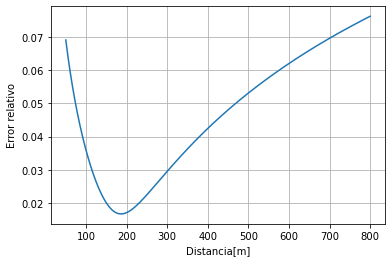

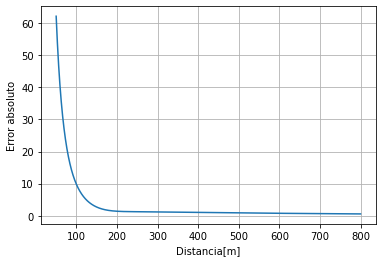

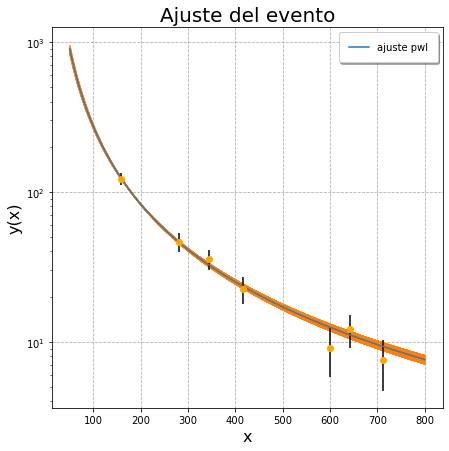

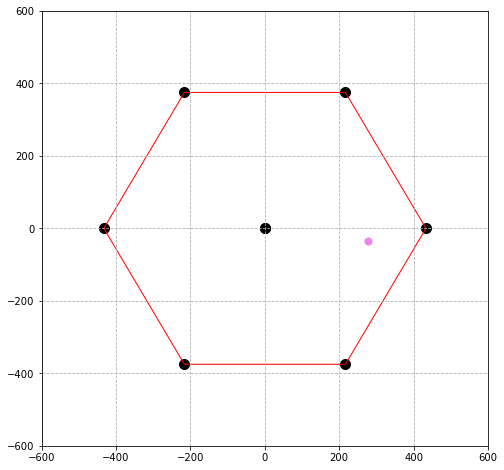

Distancias: [600.11887285 345.15614652 158.70116054 415.04909024 642.8651829
 712.68324165 280.54759745]
Estimación de s0: 41.12 ± 1.21
Estimación de b_est: 1.72 ± 0.05
Coeff corr -0.8252785512569264
sigma_b 0.051038671039403474
sigma_s0 1.21437686991949
cov_s0_b -0.05115091446237118


(array([93.58650563]), array([1.56068956]))

In [6]:
test = evento(poligono,pointsx,pointsy,True,True,True,True,0) 
test

Defino los puntos del hexagono. Me genero un punto al azar que vive dentro del hexagono. Grafico

In [17]:
min_error = np.zeros(1000)
for i in range(len(min_error)):
    min_error[i]=evento(poligono,pointsx,pointsy,False,False,False,False,0) 

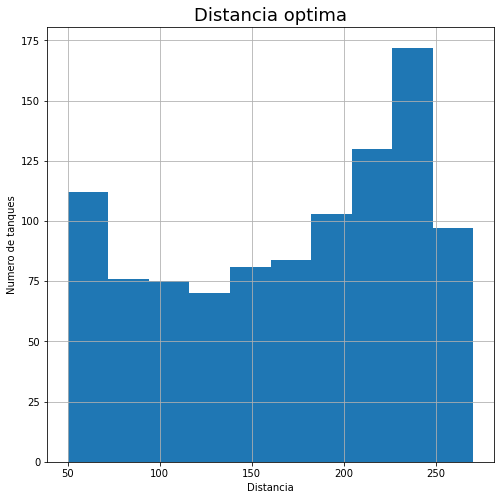

In [26]:
plt.figure(figsize=(8,8))
plt.title('Distancia optima',size = 18)
plt.hist(min_error)
plt.xlabel('Distancia')
plt.ylabel('Numero de tanques')
plt.grid()

In [22]:
angles = np.linspace(0,40,11)
mean = np.zeros(len(angles))
median = np.zeros(len(angles))

for i in range(len(angles)):
    dist_optima = np.zeros(1000)
    for j in range(len(dist_optima)):
        dist_optima[j] = evento(poligono,pointsx,pointsy,False,False,False,False,angles[i])
    mean[i] = np.mean(dist_optima)
    median[i] = np.median(dist_optima)

<ipython-input-16-360f15768bb8>:50: RuntimeWarning: overflow encountered in power
  return s0*(r/r0)**(-b)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

In [ ]:
plt.figure(figsize=(8,8))
plt.title('Dist optima en función del ángulo',size = 16)
plt.plot(angles,mean,label = 'Promedio')
plt.plot(angles,median, label = 'Mediana')
plt.plot(angles,mean,'o',color='blue')
plt.plot(angles,median,'o',color='orange')
plt.xlabel('Angulos [deg]',size=14)
plt.ylabel('Distancia [m]',size=14)
plt.grid(linestyle = '--')
plt.legend(fontsize=16)